# Tutorial: Analysis (work in progress)

## Initial imports

In [1]:
from datetime import datetime
from straklip import config, input_tables
from straklip.steps import analysis
from straklip.stralog import getLogger
import os
import pkg_resources as pkg

First, we need to initialize the logger here.

In [2]:
if 'SHARED_LOG_FILE' not in os.environ:
    os.environ['SHARED_LOG_FILE'] = f'straklip_{datetime.now().strftime("%Y-%m-%d_%H%M")}.log'

getLogger('straklip', setup=True, logfile=os.environ['SHARED_LOG_FILE'],debu=False,
          configfile=pkg.resource_filename('straklip', './config/logging.yaml'))

<Logger straklip (DEBUG)>

Two pipeline configuration files are stored in the `tutorials/pipeline_logs`, directory, namely `pipe.yaml` and `data.yaml`. A more in-deep explanation of these file, is presented here: https://straklip.readthedocs.io/latest/quick_start.html. We start by loading into the pipeline as follow. Remember, to manipulate the options for each specific step, we can change the entries in the 'pipe.yaml' accordingly, or change them from a line of code like `pipe_cfg.analysis['steps']['extract_candidate']=True`,  before running the step.
For this tutorial we will start form the previously generated dataframes from the pipeline.

In [3]:
pipe_cfg='/Users/gstrampelli/StraKLIP/docs/source/tutorials/work/pipeline_logs/pipe.yaml' #or where these files are
data_cfg='/Users/gstrampelli/StraKLIP/docs/source/tutorials/work/pipeline_logs/data.yaml'
pipe_cfg = config.configure_pipeline(pipe_cfg,pipe_cfg=pipe_cfg,data_cfg=data_cfg,dt_string=datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
data_cfg = config.configure_data(data_cfg,pipe_cfg)

2025-06-19 10:24:23 straklip.config             :INFO     (configure_pipeline:70[pid=24180]) 
StraKLIP pipeline started at date and time: 19/06/2025 10:24:23
Pipe_cfg: /Users/gstrampelli/StraKLIP/docs/source/tutorials/work/pipeline_logs/pipe.yaml
Data_cfg: /Users/gstrampelli/StraKLIP/docs/source/tutorials/work/pipeline_logs/data.yaml

2025-06-19 10:24:23 straklip.config             :INFO     (configure_data:151[pid=24180]) Validation of default labels and data successful!


## Loading the dataframe

Once the "pipe_cfg" and the "data_cfg" are configuration, we can load pre-existing dataframes.

In this case we use "skip_originals" True and "load" True to tell the pipeline tom not look for inpout catalogs, but for the dataframe already generated by the pipeline.

NOTE: for this tutorial, we are forcing the pipeline to work on only the "unq_id" 52 to speed up the process, as follow (you can achieve the same result by changing the "unq_ids_list" option in the "pipe.yaml"):

In [4]:
dataset = input_tables.Tables(data_cfg, pipe_cfg, skip_originals=True)
DF = config.configure_dataframe(dataset,load=True)

2025-06-19 10:24:26 straklip.config             :WARNING  (configure_dataframe:224[pid=24180]) get_Av_dict currently only supports VEGAmag system. Please provide your own set of AVs if in a differest system as AVs : {ext: {mag_filter : value}} in the data.yaml under target
2025-06-19 10:24:26 straklip.utils.ancillary    :INFO     (get_Av_dict:424[pid=24180]) before dust, V =  0.0 mag(VEGA)
2025-06-19 10:24:26 straklip.utils.ancillary    :INFO     (get_Av_dict:425[pid=24180]) after dust, V = 1.0146 mag(VEGA)
2025-06-19 10:24:27 straklip.utils.ancillary    :INFO     (get_Av_dict:444[pid=24180]) Av = 1.0146 mag


2025-06-19 10:24:27 straklip.utils.ancillary    :INFO     (get_Av_dict:488[pid=24180]) AV=0 wfc3,uvis2,f814w 0.0 mag(VEGA)
2025-06-19 10:24:27 straklip.utils.ancillary    :INFO     (get_Av_dict:489[pid=24180]) AV=1 wfc3,uvis2,f814w 0.6094 mag
2025-06-19 10:24:27 straklip.utils.ancillary    :INFO     (get_Av_dict:488[pid=24180]) AV=0 wfc3,uvis2,f850lp 0.0 mag(VEGA)
2025-06-19 10:24:27 straklip.utils.ancillary    :INFO     (get_Av_dict:489[pid=24180]) AV=1 wfc3,uvis2,f850lp 0.4694 mag
2025-06-19 10:24:27 straklip.config             :INFO     (configure_dataframe:270[pid=24180]) Fetching dataframes from /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out


In [5]:
DF.keys

['unq_targets',
 'crossmatch_ids',
 'mvs_targets',
 'mvs_candidates',
 'unq_candidates']

In [6]:
DF.mvs_targets_df

,mvs_ids,x_f814w,x_f850lp,y_f814w,y_f850lp,vis,ext,counts_f814w,counts_f850lp,ecounts_f814w,...,e_f814w_ap,counts_f850lp_ap,ecounts_f850lp_ap,nsky_f850lp_ap,m_f850lp_ap,e_f850lp_ap,delta_f814w,edelta_f814w,delta_f850lp,edelta_f850lp
0,0,766.682062,766.297865,869.519962,870.863230,13,1,10050.176567,8147.884608,103.716767,...,0.014363,5112.833,75.324845,25.0,21.160546,0.017460,24.616,0.003,23.301,0.007
1,1,769.100793,768.870891,866.146099,866.488792,1,1,37148.970247,29523.416694,200.603377,...,0.007916,18404.541,140.319831,25.0,19.769888,0.010841,24.616,0.003,23.301,0.007
2,2,762.415167,762.213142,869.798303,870.180384,2,1,20888.773322,16756.185268,150.306225,...,0.010224,10545.567,107.937060,25.0,20.380608,0.013133,24.616,0.003,23.301,0.007
3,3,765.630228,765.408206,867.979551,868.467341,3,1,19851.347253,17782.298850,146.991839,...,0.010455,11221.743,109.214962,25.0,20.307049,0.012675,24.616,0.003,23.301,0.007
4,4,767.251059,767.009600,867.473929,867.939866,4,1,18535.997643,17143.439224,141.164681,...,0.010770,10739.130,107.621370,25.0,20.354777,0.012938,24.616,0.003,23.301,0.007
5,5,766.601507,766.336710,868.267308,868.601284,5,1,21899.906087,19840.838076,152.199777,...,0.009887,12351.680,115.865474,25.0,20.208967,0.012358,24.616,0.003,23.301,0.007
6,6,767.081804,766.867054,866.901849,867.166727,6,1,10821.808262,9736.723197,111.510075,...,0.014225,6046.163,81.943106,25.0,20.978500,0.016295,24.616,0.003,23.301,0.007
7,7,765.825833,765.608929,868.625604,869.098238,7,1,14345.541776,12125.508627,123.726601,...,0.012105,7633.587,90.881860,25.0,20.725378,0.014700,24.616,0.003,23.301,0.007
8,8,765.740929,765.619928,868.295724,868.761725,8,1,12134.206337,9881.013676,116.470224,...,0.013329,6125.534,82.390402,25.0,20.964340,0.016194,24.616,0.003,23.301,0.007
9,9,762.743761,762.620949,866.727766,866.796443,9,1,12163.774100,9674.484288,118.946485,...,0.013511,6044.626,82.730407,25.0,20.978776,0.016426,24.616,0.003,23.301,0.007


## Running the analysis

The next step wil perform a more in depth analysis of each candidate. Manipulating the options in the "pipe.yaml" under the "analysis" block we can perform raw contrast curves, calibrated contrast curves, the extraction of a candidate though forward modeling and MCMC fitting.

### Candidate Extraction

Note in this example we limit the analysis to just one target, setting the use unq_ids_list: [52].

In [7]:
pipe_cfg.unq_ids_list = [11]

 In the following we force the pipeline to just run  the extract_candidate step, and we ensure that all the other step of the analysis are turned off.

In [8]:
pipe_cfg.analysis['steps']['extract_candidate']=True
pipe_cfg.analysis['steps']['contrast_curves']=False
pipe_cfg.analysis['steps']['cal_contrast_curves']=False
pipe_cfg.analysis['steps']['mass_sensitivity_curves']=False
analysis.run({'DF': DF, 'dataset': dataset})

2025-06-19 10:24:41 straklip.steps.analysis     :INFO     (run:1454[pid=24180]) Running Analysis step
2025-06-19 10:24:41 straklip.config             :INFO     (make_paths:112[pid=24180]) Creating "/Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/"
2025-06-19 10:24:41 straklip.steps.analysis     :INFO     (setup_DATASET:87[pid=24180]) Setting up Dataset for observation
2025-06-19 10:24:41 straklip.steps.analysis     :INFO     (generate_psflib:108[pid=24180]) Generating PSF library
2025-06-19 10:24:41 straklip.steps.analysis     :INFO     (candidate_extraction:914[pid=24180]) Extracting candidate from: ['/Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/mvs_tiles/f814w/tile_ID11.fits']
2025-06-19 10:24:41 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:24:45 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.489, error: [ 0.007 -0.007]
2025-06-19 10:24:45 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:24:46 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_1_extracted.yaml
2025-06-19 10:24:46 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:24:50 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.653, error: [ 0.009 -0.01 ]
2025-06-19 10:24:50 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:24:51 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_2_extracted.yaml
2025-06-19 10:24:51 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:24:55 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.635, error: [ 0.009 -0.009]
2025-06-19 10:24:55 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:24:55 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_3_extracted.yaml
2025-06-19 10:24:55 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:00 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.566, error: [ 0.008 -0.009]
2025-06-19 10:25:00 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:00 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_4_extracted.yaml
2025-06-19 10:25:00 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:04 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.569, error: [ 0.008 -0.008]
2025-06-19 10:25:04 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:05 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_5_extracted.yaml
2025-06-19 10:25:05 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:09 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.496, error: [ 0.007 -0.007]
2025-06-19 10:25:09 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:10 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_6_extracted.yaml
2025-06-19 10:25:10 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:15 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.652, error: [ 0.01  -0.008]
2025-06-19 10:25:15 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:15 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_7_extracted.yaml
2025-06-19 10:25:15 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:20 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.566, error: [ 0.008 -0.008]
2025-06-19 10:25:20 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:20 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_8_extracted.yaml
2025-06-19 10:25:20 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:25 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.554, error: [ 0.008 -0.008]
2025-06-19 10:25:25 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:25 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_9_extracted.yaml
2025-06-19 10:25:25 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:30 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.592, error: [ 0.008 -0.009]
2025-06-19 10:25:30 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:30 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_10_extracted.yaml
2025-06-19 10:25:30 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:35 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.646, error: [ 0.008 -0.009]
2025-06-19 10:25:35 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:35 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f814w_cand_11_extracted.yaml
2025-06-19 10:25:35 straklip.steps.analysis     :WARNING  (run_analysis:1448[pid=24180]) Cannot convert contrast curves in mass sensistivity curves without an interpolator!
2025-06-19 10:25:35 straklip.steps.analysis     :INFO     (setup_DATASET:87[pid=24180]) Setting up Dataset for observation
2025-06-19 10:25:36 straklip.steps.analysis     :INFO     (gener

/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:40 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.75, error: [ 0.013 -0.013]
2025-06-19 10:25:40 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:41 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_1_extracted.yaml
2025-06-19 10:25:41 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:45 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.589, error: [ 0.01  -0.011]
2025-06-19 10:25:45 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:45 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_2_extracted.yaml
2025-06-19 10:25:45 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:50 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.698, error: [ 0.013 -0.012]
2025-06-19 10:25:50 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:51 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_3_extracted.yaml
2025-06-19 10:25:51 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:25:55 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.592, error: [ 0.01 -0.01]
2025-06-19 10:25:55 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:25:56 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_4_extracted.yaml
2025-06-19 10:25:56 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:26:00 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.726, error: [ 0.014 -0.012]
2025-06-19 10:26:00 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:26:01 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_5_extracted.yaml
2025-06-19 10:26:01 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:26:05 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.735, error: [ 0.013 -0.012]
2025-06-19 10:26:05 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:26:06 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_6_extracted.yaml
2025-06-19 10:26:06 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:26:10 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.657, error: [ 0.011 -0.011]
2025-06-19 10:26:10 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:26:11 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_7_extracted.yaml
2025-06-19 10:26:11 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:26:15 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.614, error: [ 0.011 -0.01 ]
2025-06-19 10:26:15 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:26:16 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_8_extracted.yaml
2025-06-19 10:26:16 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:26:20 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.605, error: [ 0.011 -0.01 ]
2025-06-19 10:26:20 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:26:21 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_9_extracted.yaml
2025-06-19 10:26:21 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:26:25 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.618, error: [ 0.01 -0.01]
2025-06-19 10:26:25 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:26:26 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_10_extracted.yaml
2025-06-19 10:26:26 straklip.steps.analysis     :INFO     (run_FMAstrometry:698[pid=24180]) Running forward modeling


/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)



2025-06-19 10:26:30 straklip.steps.analysis     :INFO     (run_FMAstrometry:779[pid=24180])  contrast: 0.717, error: [ 0.012 -0.012]
2025-06-19 10:26:30 straklip.steps.analysis     :INFO     (fit_astrometry:865[pid=24180]) Saving MCMC plots in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction/
2025-06-19 10:26:31 straklip.steps.analysis     :INFO     (candidate_extraction:929[pid=24180]) Saving candidate dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/testPSF4extraction//f850lp_cand_11_extracted.yaml
2025-06-19 10:26:31 straklip.steps.analysis     :WARNING  (run_analysis:1448[pid=24180]) Cannot convert contrast curves in mass sensistivity curves without an interpolator!


### Raw Contrast Curves

In [9]:
pipe_cfg.analysis['steps']['extract_candidate']=False
pipe_cfg.analysis['steps']['contrast_curves']=True
pipe_cfg.analysis['steps']['cal_contrast_curves']=False
pipe_cfg.analysis['steps']['mass_sensitivity_curves']=False
analysis.run({'DF': DF, 'dataset': dataset})

2025-06-19 10:26:44 straklip.steps.analysis     :INFO     (run:1454[pid=24180]) Running Analysis step
2025-06-19 10:26:44 straklip.config             :INFO     (make_paths:115[pid=24180]) "/Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/" exists, and will not be created.
2025-06-19 10:26:44 straklip.steps.analysis     :INFO     (setup_DATASET:87[pid=24180]) Setting up Dataset for observation
2025-06-19 10:26:44 straklip.steps.analysis     :INFO     (generate_psflib:108[pid=24180]) Generating PSF library
2025-06-19 10:26:44 straklip.steps.analysis     :INFO     (mk_contrast_curves:1058[pid=24180]) Making contrast curves.
2025-06-19 10:26:44 straklip.steps.analysis     :INFO     (mk_contrast_curves:1062[pid=24180]) Loading candidate dictionary from file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/extracted_candidate/f814w_extracted.yaml
2025-06-19 10:26:44 straklip.steps.analysis     :INFO     (mk_contrast_curves:1065[pid=24180]) Lo

  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:26:48 straklip.steps.analysis     :INFO     (mk_contrast_curves:1071[pid=24180]) Loading residuas from file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/masked_candidates/f814w-res_masked-KLmodes-all.fits
2025-06-19 10:26:48 straklip.steps.analysis     :INFO     (mk_contrast_curves:1112[pid=24180]) Saving contrast curves plot in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11
2025-06-19 10:26:48 straklip.steps.analysis     :INFO     (mk_contrast_curves:1136[pid=24180]) residual masked plot in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11
2025-06-19 10:26:49 straklip.steps.analysis     :INFO     (mk_contrast_curves:1146[pid=24180]) Saving contrast curves dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/f814w_contrast_curves.pkl
2025-06-19 10:26:49 straklip.steps.analysis     :WARNING  (run_analysis:1448[pid=24180]) Cannot convert contra

  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:26:53 straklip.steps.analysis     :INFO     (mk_contrast_curves:1071[pid=24180]) Loading residuas from file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/masked_candidates/f850lp-res_masked-KLmodes-all.fits
2025-06-19 10:26:53 straklip.steps.analysis     :INFO     (mk_contrast_curves:1112[pid=24180]) Saving contrast curves plot in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11
2025-06-19 10:26:53 straklip.steps.analysis     :INFO     (mk_contrast_curves:1136[pid=24180]) residual masked plot in: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11
2025-06-19 10:26:53 straklip.steps.analysis     :INFO     (mk_contrast_curves:1146[pid=24180]) Saving contrast curves dictionary to file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/ID11/f850lp_contrast_curves.pkl
2025-06-19 10:26:53 straklip.steps.analysis     :WARNING  (run_analysis:1448[pid=24180]) Cannot convert cont

### Calibrated Contrast Curves

2025-06-19 10:27:08 straklip.steps.analysis     :INFO     (run:1454[pid=24180]) Running Analysis step
2025-06-19 10:27:08 straklip.config             :INFO     (make_paths:115[pid=24180]) "/Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/" exists, and will not be created.
2025-06-19 10:27:08 straklip.steps.analysis     :INFO     (setup_DATASET:87[pid=24180]) Setting up Dataset for observation
2025-06-19 10:27:08 straklip.steps.analysis     :INFO     (generate_psflib:108[pid=24180]) Generating PSF library
2025-06-19 10:27:08 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1151[pid=24180]) Making corrected contrast curves.
2025-06-19 10:27:08 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1154[pid=24180]) Loading masked candidate data.
2025-06-19 10:27:08 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1163[pid=24180]) Loading contrast curves dictionary from file: /Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/ou

  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:12 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 2 at pa: 45, sep: 0.922, flux: 29672399.186782785


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:17 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 3 at pa: 90, sep: 0.922, flux: 29672399.186782785


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:21 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 4 at pa: 135, sep: 0.922, flux: 29672399.186782785


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:25 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 5 at pa: 180, sep: 0.922, flux: 29672399.186782785


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:30 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 6 at pa: 225, sep: 0.922, flux: 29672399.186782785


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:34 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 7 at pa: 270, sep: 0.922, flux: 29672399.186782785


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:38 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 8 at pa: 315, sep: 0.922, flux: 29672399.186782785


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:43 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 9 at pa: 0, sep: 1.844, flux: 841.0646415554554


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:47 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 10 at pa: 45, sep: 1.844, flux: 841.0646415554554


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:51 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 11 at pa: 90, sep: 1.844, flux: 841.0646415554554


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:27:56 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 12 at pa: 135, sep: 1.844, flux: 841.0646415554554


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:00 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 13 at pa: 180, sep: 1.844, flux: 841.0646415554554


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:04 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 14 at pa: 225, sep: 1.844, flux: 841.0646415554554


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:09 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 15 at pa: 270, sep: 1.844, flux: 841.0646415554554


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:13 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 16 at pa: 315, sep: 1.844, flux: 841.0646415554554


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:18 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 17 at pa: 0, sep: 2.766, flux: 302.4233132853525


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:22 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 18 at pa: 45, sep: 2.766, flux: 302.4233132853525


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:26 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 19 at pa: 90, sep: 2.766, flux: 302.4233132853525


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:31 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 20 at pa: 135, sep: 2.766, flux: 302.4233132853525


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:35 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 21 at pa: 180, sep: 2.766, flux: 302.4233132853525


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:39 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 22 at pa: 225, sep: 2.766, flux: 302.4233132853525


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:44 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 23 at pa: 270, sep: 2.766, flux: 302.4233132853525


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:48 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 24 at pa: 315, sep: 2.766, flux: 302.4233132853525


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:52 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 25 at pa: 0, sep: 3.688, flux: 192.2588144219906


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:28:57 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 26 at pa: 45, sep: 3.688, flux: 192.2588144219906


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:01 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 27 at pa: 90, sep: 3.688, flux: 192.2588144219906


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:05 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 28 at pa: 135, sep: 3.688, flux: 192.2588144219906


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:10 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 29 at pa: 180, sep: 3.688, flux: 192.2588144219906


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:14 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 30 at pa: 225, sep: 3.688, flux: 192.2588144219906


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:18 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 31 at pa: 270, sep: 3.688, flux: 192.2588144219906


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:23 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 32 at pa: 315, sep: 3.688, flux: 192.2588144219906


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:27 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 33 at pa: 0, sep: 4.61, flux: 145.66207223034266


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:32 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 34 at pa: 45, sep: 4.61, flux: 145.66207223034266


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:36 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 35 at pa: 90, sep: 4.61, flux: 145.66207223034266


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:40 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 36 at pa: 135, sep: 4.61, flux: 145.66207223034266


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:45 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 37 at pa: 180, sep: 4.61, flux: 145.66207223034266


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:49 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 38 at pa: 225, sep: 4.61, flux: 145.66207223034266


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:53 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 39 at pa: 270, sep: 4.61, flux: 145.66207223034266


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:29:58 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 40 at pa: 315, sep: 4.61, flux: 145.66207223034266


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:02 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 41 at pa: 0, sep: 5.532, flux: 113.34720028913645


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:07 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 42 at pa: 45, sep: 5.532, flux: 113.34720028913645


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:11 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 43 at pa: 90, sep: 5.532, flux: 113.34720028913645


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:15 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 44 at pa: 135, sep: 5.532, flux: 113.34720028913645


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:20 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 45 at pa: 180, sep: 5.532, flux: 113.34720028913645


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:24 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 46 at pa: 225, sep: 5.532, flux: 113.34720028913645


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:28 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 47 at pa: 270, sep: 5.532, flux: 113.34720028913645


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:33 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 48 at pa: 315, sep: 5.532, flux: 113.34720028913645


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:37 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 49 at pa: 0, sep: 6.454, flux: 94.33479173710143


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:41 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 50 at pa: 45, sep: 6.454, flux: 94.33479173710143


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:46 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 51 at pa: 90, sep: 6.454, flux: 94.33479173710143


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:50 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 52 at pa: 135, sep: 6.454, flux: 94.33479173710143


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:54 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 53 at pa: 180, sep: 6.454, flux: 94.33479173710143


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:30:58 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 54 at pa: 225, sep: 6.454, flux: 94.33479173710143


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:03 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 55 at pa: 270, sep: 6.454, flux: 94.33479173710143


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:07 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 56 at pa: 315, sep: 6.454, flux: 94.33479173710143


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:12 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 57 at pa: 0, sep: 7.376, flux: 61.76198509689058


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:16 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 58 at pa: 45, sep: 7.376, flux: 61.76198509689058


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:21 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 59 at pa: 90, sep: 7.376, flux: 61.76198509689058


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:25 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 60 at pa: 135, sep: 7.376, flux: 61.76198509689058


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:29 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 61 at pa: 180, sep: 7.376, flux: 61.76198509689058


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:34 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 62 at pa: 225, sep: 7.376, flux: 61.76198509689058


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:38 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 63 at pa: 270, sep: 7.376, flux: 61.76198509689058


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:42 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 64 at pa: 315, sep: 7.376, flux: 61.76198509689058


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:47 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 65 at pa: 0, sep: 8.298, flux: 47.59556716206335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:51 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 66 at pa: 45, sep: 8.298, flux: 47.59556716206335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:31:56 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 67 at pa: 90, sep: 8.298, flux: 47.59556716206335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:00 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 68 at pa: 135, sep: 8.298, flux: 47.59556716206335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:04 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 69 at pa: 180, sep: 8.298, flux: 47.59556716206335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:09 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 70 at pa: 225, sep: 8.298, flux: 47.59556716206335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:13 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 71 at pa: 270, sep: 8.298, flux: 47.59556716206335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:18 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 72 at pa: 315, sep: 8.298, flux: 47.59556716206335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:22 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 73 at pa: 0, sep: 9.22, flux: 47.26748411680277


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:27 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 74 at pa: 45, sep: 9.22, flux: 47.26748411680277


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:31 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 75 at pa: 90, sep: 9.22, flux: 47.26748411680277


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:35 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 76 at pa: 135, sep: 9.22, flux: 47.26748411680277


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:40 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 77 at pa: 180, sep: 9.22, flux: 47.26748411680277


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:44 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 78 at pa: 225, sep: 9.22, flux: 47.26748411680277


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:49 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 79 at pa: 270, sep: 9.22, flux: 47.26748411680277


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:53 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 80 at pa: 315, sep: 9.22, flux: 47.26748411680277


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:32:58 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 81 at pa: 0, sep: 10.142000000000001, flux: 42.38257329440012


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:02 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 82 at pa: 45, sep: 10.142000000000001, flux: 42.38257329440012


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:06 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 83 at pa: 90, sep: 10.142000000000001, flux: 42.38257329440012


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:10 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 84 at pa: 135, sep: 10.142000000000001, flux: 42.38257329440012


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:15 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 85 at pa: 180, sep: 10.142000000000001, flux: 42.38257329440012


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:19 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 86 at pa: 225, sep: 10.142000000000001, flux: 42.38257329440012


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:23 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 87 at pa: 270, sep: 10.142000000000001, flux: 42.38257329440012


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:28 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 88 at pa: 315, sep: 10.142000000000001, flux: 42.38257329440012


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:32 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 89 at pa: 0, sep: 11.064000000000002, flux: 38.98711824724749


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:36 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 90 at pa: 45, sep: 11.064000000000002, flux: 38.98711824724749


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:41 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 91 at pa: 90, sep: 11.064000000000002, flux: 38.98711824724749


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:45 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 92 at pa: 135, sep: 11.064000000000002, flux: 38.98711824724749


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:50 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 93 at pa: 180, sep: 11.064000000000002, flux: 38.98711824724749


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:54 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 94 at pa: 225, sep: 11.064000000000002, flux: 38.98711824724749


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:33:58 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 95 at pa: 270, sep: 11.064000000000002, flux: 38.98711824724749


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:03 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 96 at pa: 315, sep: 11.064000000000002, flux: 38.98711824724749


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:07 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 97 at pa: 0, sep: 11.986, flux: 36.89098569223733


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:11 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 98 at pa: 45, sep: 11.986, flux: 36.89098569223733


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:15 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 99 at pa: 90, sep: 11.986, flux: 36.89098569223733


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:20 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 100 at pa: 135, sep: 11.986, flux: 36.89098569223733


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:24 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 101 at pa: 180, sep: 11.986, flux: 36.89098569223733


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:29 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 102 at pa: 225, sep: 11.986, flux: 36.89098569223733


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:33 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 103 at pa: 270, sep: 11.986, flux: 36.89098569223733


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:37 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 104 at pa: 315, sep: 11.986, flux: 36.89098569223733


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:42 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 105 at pa: 0, sep: 12.908000000000001, flux: 33.49335268435086


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:46 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 106 at pa: 45, sep: 12.908000000000001, flux: 33.49335268435086


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:50 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 107 at pa: 90, sep: 12.908000000000001, flux: 33.49335268435086


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:54 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 108 at pa: 135, sep: 12.908000000000001, flux: 33.49335268435086


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:34:59 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 109 at pa: 180, sep: 12.908000000000001, flux: 33.49335268435086


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:03 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 110 at pa: 225, sep: 12.908000000000001, flux: 33.49335268435086


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:07 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 111 at pa: 270, sep: 12.908000000000001, flux: 33.49335268435086


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:12 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 112 at pa: 315, sep: 12.908000000000001, flux: 33.49335268435086


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:16 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 113 at pa: 0, sep: 13.830000000000002, flux: 34.979301889771335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:21 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 114 at pa: 45, sep: 13.830000000000002, flux: 34.979301889771335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:25 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 115 at pa: 90, sep: 13.830000000000002, flux: 34.979301889771335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:30 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 116 at pa: 135, sep: 13.830000000000002, flux: 34.979301889771335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:34 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 117 at pa: 180, sep: 13.830000000000002, flux: 34.979301889771335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:38 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 118 at pa: 225, sep: 13.830000000000002, flux: 34.979301889771335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:43 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 119 at pa: 270, sep: 13.830000000000002, flux: 34.979301889771335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:47 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 120 at pa: 315, sep: 13.830000000000002, flux: 34.979301889771335


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:51 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 121 at pa: 0, sep: 14.752, flux: 36.64567173077913


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:35:56 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 122 at pa: 45, sep: 14.752, flux: 36.64567173077913


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:00 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 123 at pa: 90, sep: 14.752, flux: 36.64567173077913


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:04 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 124 at pa: 135, sep: 14.752, flux: 36.64567173077913


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:09 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 125 at pa: 180, sep: 14.752, flux: 36.64567173077913


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:13 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 126 at pa: 225, sep: 14.752, flux: 36.64567173077913


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:17 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 127 at pa: 270, sep: 14.752, flux: 36.64567173077913


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:22 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 128 at pa: 315, sep: 14.752, flux: 36.64567173077913


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:26 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 129 at pa: 0, sep: 15.674000000000001, flux: 38.22707458731996


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:31 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 130 at pa: 45, sep: 15.674000000000001, flux: 38.22707458731996


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:35 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 131 at pa: 90, sep: 15.674000000000001, flux: 38.22707458731996


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:39 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 132 at pa: 135, sep: 15.674000000000001, flux: 38.22707458731996


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:44 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 133 at pa: 180, sep: 15.674000000000001, flux: 38.22707458731996


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:48 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 134 at pa: 225, sep: 15.674000000000001, flux: 38.22707458731996


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:52 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 135 at pa: 270, sep: 15.674000000000001, flux: 38.22707458731996


  0%|          | 0/1 [00:00<?, ?it/s]

2025-06-19 10:36:57 straklip.steps.analysis     :INFO     (mk_cal_contrast_curves:1189[pid=24180]) Injecting fake 136 at pa: 315, sep: 15.674000000000001, flux: 38.22707458731996


  0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fakes.py:702: RuntimeWarning: divide by zero encountered in divide
  gmask = np.exp(-(xfitbox**2+yfitbox**2)/(2.*sigma**2))
/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fakes.py:702: RuntimeWarning: invalid value encountered in divide
  gmask = np.exp(-(xfitbox**2+yfitbox**2)/(2.*sigma**2))
/opt/miniconda3/envs/straKLIP/lib/python3.11/site-packages/pyklip/fakes.py:705: RuntimeWarning: invalid value encountered in scalar divide
  corrflux = np.nansum(fitbox*gmask)/np.sum(gmask*gmask)
/opt/miniconda3/envs/straK

TypeError: Improper input: func input vector length N=4 must not exceed func output vector length M=0

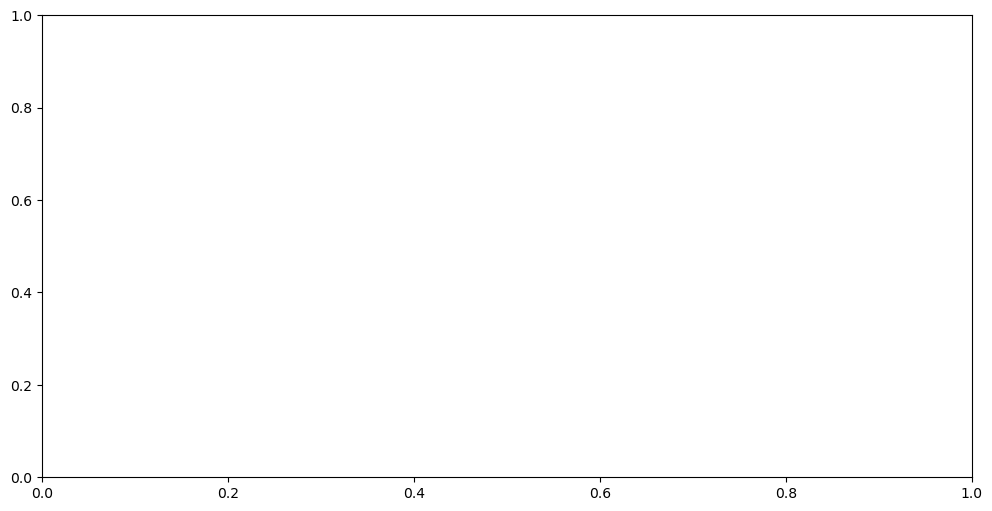

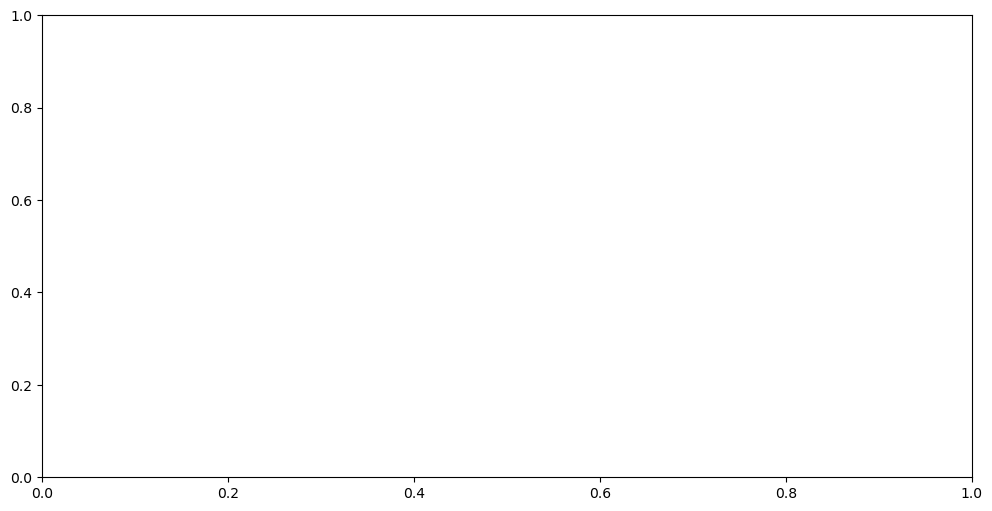

In [10]:
pipe_cfg.analysis['steps']['extract_candidate']=False
pipe_cfg.analysis['steps']['contrast_curves']=False
pipe_cfg.analysis['steps']['cal_contrast_curves']=True
pipe_cfg.analysis['steps']['mass_sensitivity_curves']=False
analysis.run({'DF': DF, 'dataset': dataset})

### Contrast to mass conversion (work in progress)

To convert contrast to masses, we use user provided interpolator that will transform (mag,age) -> (mass), (mag,age) -> (teff), (mag,age) -> (logR). This interpolator should be assemble as a series of dictionaries such as interp = {filter: {'logmass': (mag,age) -> (mass), 'teff': (mag,age) -> (teff), 'logR': (mag,age) -> (logR)}}.
First we convert the contrast for detect companion

In [11]:
pipe_cfg.analysis['path2iso_interp']='path/to/user/interpolator.pkl'
pipe_cfg.analysis['steps']['extract_candidate']=True
pipe_cfg.analysis['steps']['contrast_curves']=False
pipe_cfg.analysis['steps']['cal_contrast_curves']=False
pipe_cfg.analysis['steps']['mass_sensitivity_curves']=False
analysis.run({'DF': DF, 'dataset': dataset})

2025-06-19 10:40:21 straklip.steps.analysis     :INFO     (run:1454[pid=24180]) Running Analysis step
2025-06-19 10:40:21 straklip.config             :INFO     (make_paths:115[pid=24180]) "/Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/analysis/" exists, and will not be created.
2025-06-19 10:40:21 straklip.steps.analysis     :INFO     (setup_DATASET:87[pid=24180]) Setting up Dataset for observation
2025-06-19 10:40:21 straklip.steps.analysis     :INFO     (generate_psflib:108[pid=24180]) Generating PSF library
2025-06-19 10:40:21 straklip.steps.analysis     :INFO     (candidate_extraction:914[pid=24180]) Extracting candidate from: ['/Users/gstrampelli/PycharmProjects/StraKLIP_tutorial_test/out/mvs_tiles/f814w/tile_ID11.fits']


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/user/interpolator.pkl'

Then we convert the calibrate contrast curves

In [ ]:
pipe_cfg.analysis['path2iso_interp']='path/to/user/interpolator.pkl'
pipe_cfg.analysis['steps']['extract_candidate']=False
pipe_cfg.analysis['steps']['contrast_curves']=False
pipe_cfg.analysis['steps']['cal_contrast_curves']=False
pipe_cfg.analysis['steps']['mass_sensitivity_curves']=True
analysis.run({'DF': DF, 'dataset': dataset})